In [309]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skimage

from skimage import exposure
from skimage.feature import hog
from skimage.filters import sobel
from skimage.feature import local_binary_pattern

# Change to match data filepath on local
# base_fp = '/Users/michelle/Desktop/W281/final_project/rendered_256x256'
base_fp = '/home/sysung98/MIDS/W281/final_project/data/rendered_256x256'

In [376]:
def hog_sobel(sketch_img_fp):
    """ apply Histogram of Oriented Gradients (HOG) to sketch image """
    sketch_img = cv2.imread(sketch_img_fp)
    gray = cv2.cvtColor(sketch_img, cv2.COLOR_BGR2GRAY)

    fd, hog_image = hog(
        gray, 
        orientations = 8, 
        pixels_per_cell = (16, 16),
        cells_per_block = (1, 1), 
        visualize = True
    )
    
    min_value = np.min(hog_image)
    max_value = np.max(hog_image)
    hog_image = exposure.rescale_intensity(
        hog_image, 
        in_range=(min_value, max_value), 
        out_range = (0, 1)
    )
    
    return hog_image, sobel(gray)

def hog_only(sketch_img_fp):
    return hog_sobel(sketch_img_fp)[0]

def sift(sketch_img_fp):
    """ apply Scale-Invariant Feature Transform (SIFT) to sketch image """
    sketch_img = cv2.imread(sketch_img_fp)
    gray = cv2.cvtColor(sketch_img, cv2.COLOR_BGR2GRAY)
    
    # Initiate SIFT object with parameters recommended for sketch images
        # nfeatures = maximum number of keypoints that SIFT will detect in an image
        # nOctaveLayers = number of layers per octave in the scale space pyramid used by SIFT; 
            # increasing will have more keypoints but with computational costs
        # contrastThreshold = minimum contrast required for a keypoint to be detected
        # edgeThreshold = threshold for rejecting edges in the keypoint detection process
        # sigma = standard deviation of the Gaussian filter used in the scale space pyramid
    sift = cv2.SIFT_create(nfeatures=350, nOctaveLayers=4, contrastThreshold=0.04, edgeThreshold=15, sigma=1.0)
    # find the keypoints on image (grayscale)
    kp = sift.detect(gray, None)
    # draw keypoints in image
    sift_image = cv2.drawKeypoints(gray, kp, None, flags=0)
    
    min_value = np.min(sift_image)
    max_value = np.max(sift_image)
    sift_image = exposure.rescale_intensity(
        sift_image, 
        in_range=(min_value, max_value), 
        out_range = (0, 1)
    )
    
    return sift_image

def lbp(sketch_img_fp):
    """ apply implement Local Binary Patterns (LBP) to sketch image """
    sketch_img = cv2.imread(sketch_img_fp)
    gray = cv2.cvtColor(sketch_img, cv2.COLOR_BGR2GRAY)
    
    # Define the LBP parameters
    radius = 4
    n_points = 8 * radius
    
    # Compute LBP
    lbp_image = local_binary_pattern(gray, n_points, radius, method='default')
    lbp_image = np.uint8((lbp_image / lbp_image.max()) * 255)

    min_value = np.min(lbp_image)
    max_value = np.max(lbp_image)
    lbp_image = exposure.rescale_intensity(
        lbp_image, 
        in_range=(min_value, max_value), 
        out_range = (0, 1)
    )
    
    return lbp_image

def edge_detection(sketch_img_fp):
    ''' apply canny edge detector to image '''
    sketch_img = cv2.imread(sketch_img_fp)
    gray = cv2.cvtColor(sketch_img, cv2.COLOR_BGR2GRAY)

    canny_img = skimage.feature.canny(
        gray, 
        sigma=4,
        high_threshold=60
    )

    return canny_img

def get_irl_photo_from_sketch(sketch_img_fp):
    """ retrieve the photo of the sketch """
    fp_split = sketch_img_fp.split('/')
    picture = fp_split[-1].split('-')[0]
    category = fp_split[-2]
    augmentation = 'tx_000100000000' if fp_split[-3] == 'tx_000100000000' else 'tx_000000000000'
 
    photo_img_fp = fp_split[:-4] + ['photo', augmentation, category, picture + '.jpg']
    return '/'.join(photo_img_fp)
    

def plot_img_sketch(sketch_img_fp, method):
    """ plot photo, sketch, and feature images """

    photo_img_fp = get_irl_photo_from_sketch(sketch_img_fp)
    photo_img = cv2.imread(photo_img_fp)
    sketch_img = cv2.imread(sketch_img_fp)

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title('/'.join(photo_img_fp.split('/')[-2:]))
    plt.imshow(photo_img, cmap='gray', vmin=0, vmax=1)

    plt.subplot(1,3,2)
    plt.title('/'.join(sketch_img_fp.split('/')[-2:]))
    plt.imshow(sketch_img, cmap='gray', vmin=0, vmax=1)

    plt.subplot(1,3,3)
    
    if method == 'hog':
        feature_img = hog_sobel(sketch_img_fp)[0]
        plt.title('HOG Descriptor')
    if method == 'sift':
        feature_img = sift(sketch_img_fp)
        plt.title('Scale-Invariant Feature Transform')
    if method == 'lbp':
        feature_img = lbp(sketch_img_fp)
        plt.title('Local Binary Patterns')
    if method == 'edge':
        feature_img = edge_detection(sketch_img_fp)
        plt.title('Outline Edge Detector')
        
    # plt.imshow(feature_img, cmap='gray')
    plt.imshow(feature_img, cmap='gray', vmin=0, vmax=1)

def get_all_sketch_img_fp(base_fp, augmentation):
    sketch_img_fp = base_fp + '/256x256/sketch/' + augmentation
    img_fp_list = []


    for categories in os.listdir(sketch_img_fp):
        category_fp = '/'.join([sketch_img_fp, categories])

        for img in os.listdir(category_fp):
            img_fp  = category_fp + '/' + img
            img_fp_list.append(img_fp)

    return img_fp_list

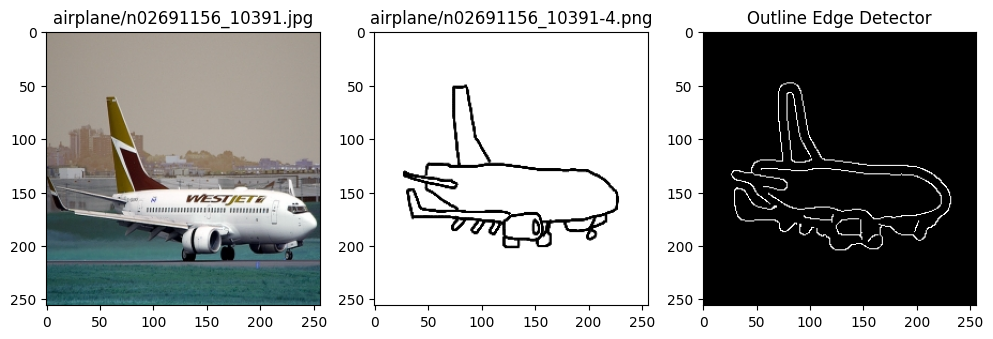

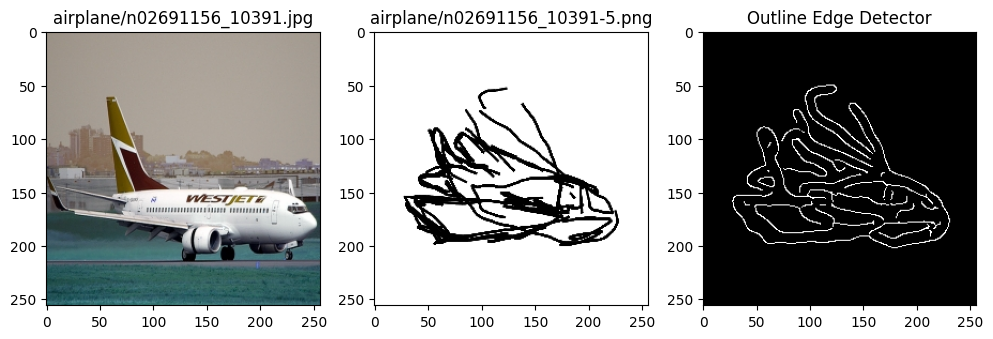

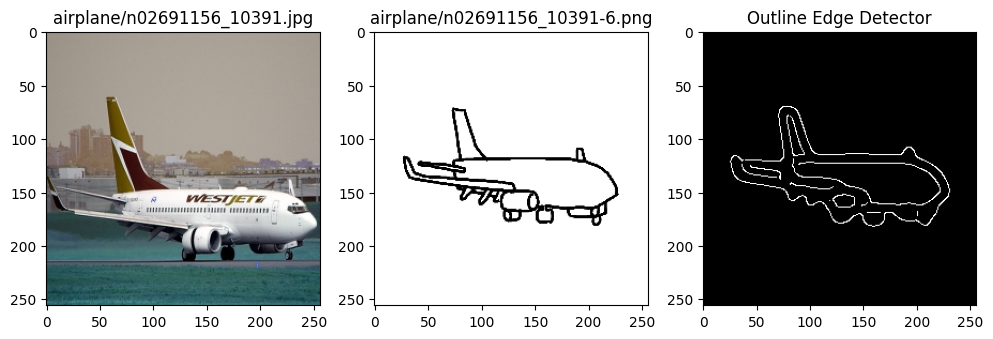

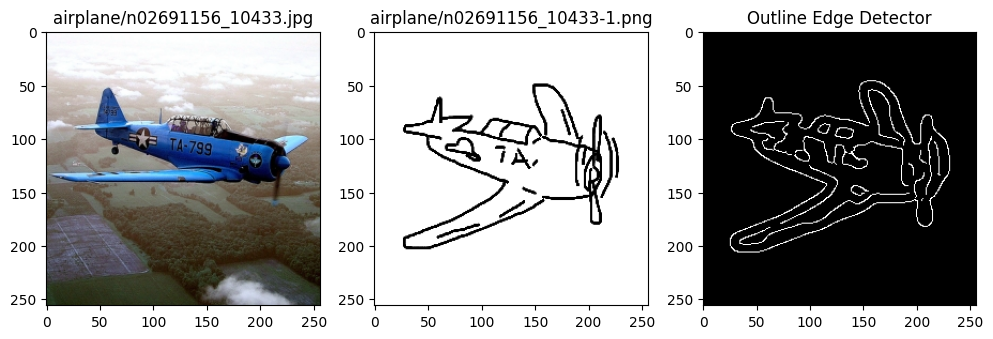

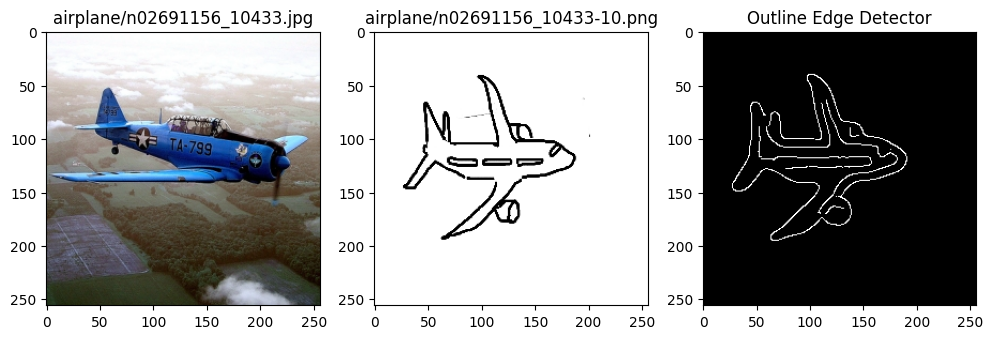

In [377]:
augmentation = 'tx_000100000000'
img_fp = sorted(get_all_sketch_img_fp(base_fp, augmentation))

for i in img_fp[30:35]:
    plot_img_sketch(i, 'edge')

In [347]:
def plot_imgs_per_category_barplt(base_fp, augmentation):
    cat_sketch_img_dict = get_category_to_sketch_img_dict(base_fp, augmentation)

    cat = list(cat_sketch_img_dict.keys())
    img_ct = list(map(lambda x: len(x), cat_sketch_img_dict.values()))

    cat_sketch_img_pd = pd.DataFrame({'img_ct': img_ct}, index=cat).sort_index()

    fig, ax = plt.subplots(figsize=(20,5))
    cat_sketch_img_pd['img_ct'].plot(kind='bar', linewidth=5)
    plt.title("Number of Images per Category")
    ax.set_yticks([300, 400, 500, 600, 700, 800])
    plt.ylim(300, 800)
    plt.tick_params(axis='x', which='major', labelsize=9)
    plt.xticks(rotation = 90)
    plt.show()

def get_category_to_sketch_img_dict(base_fp, augmentation):
    cat_sketch_img_dict = {}
    for i in get_all_sketch_img_fp(base_fp, augmentation):
        split_fp = i.split('/')
        category = split_fp[-2]
        img_name = split_fp[-1]

        if category not in cat_sketch_img_dict:
            cat_sketch_img_dict[category] = [img_name]
        else:
            cat_sketch_img_dict[category].append(img_name)
    return cat_sketch_img_dict

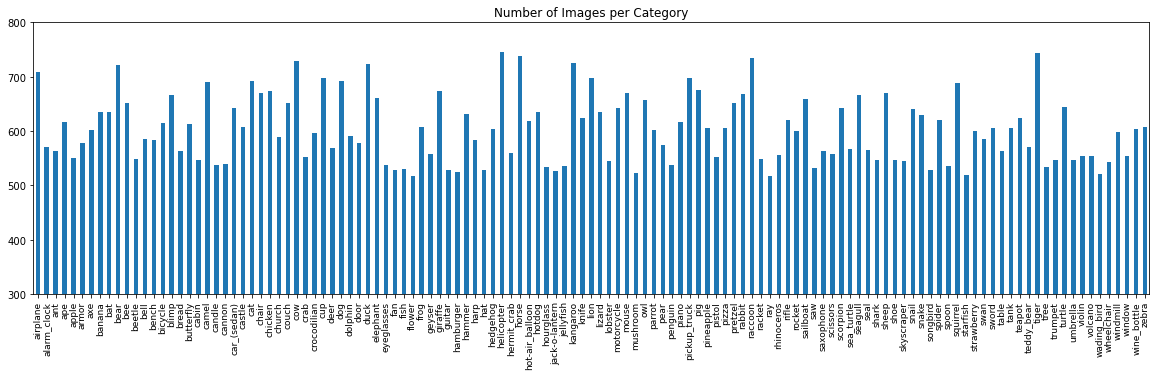

In [111]:
plot_imgs_per_category_barplt(base_fp, augmentation)

## Generate dataset of extracted features

In [3]:
from utils import ImageDataset
# base_fp = r'D:\Documents\MIDS\W281\2023-mids-w81-final-project-dataset'
base_fp = '/home/sysung98/MIDS/W281/final_project/rendered_256x256'

photo_aug = ['tx_000100000000']
sketch_aug = ['tx_000100000000']
dataset = ImageDataset.from_directory(base_fp).filter(photo_aug, sketch_aug)

Loading dataset...
Loaded 12500 unique image IDs


In [18]:
from typing import Callable, Tuple
from tqdm import tqdm  

def apply_feature_extraction(dataset: ImageDataset, func: Callable[[str], np.ndarray], name: str):
    print('Applying feature extraction...')

    for group in tqdm(dataset):
        for sketch in group.sketches:
            dest = sketch.filepath.parent.parent.parent / name / sketch.label / sketch.filepath.name
            os.makedirs(dest.parent, exist_ok=True)
            img = func(str(sketch.filepath))
            img = cv2.convertScaleAbs(img, alpha=(255.0))
            assert cv2.imwrite(str(dest), img)


In [20]:
apply_feature_extraction(dataset, hog_only, 'hog_000100000000')

Applying feature extraction...


 14%|█▎        | 1714/12500 [07:29<53:13,  3.38it/s]  